2019 Tennis Tournaments
-- 

**Introduction**

For this project, our group wanted to answer the question: How does a tennis player's age, number of aces, and serve points relate to the number of matches they won in tournaments held in 2019?

For background, an ace is when a player performs a legal serve (a shot to start the point) that is not touched by the opponent's racquet. Note that this differs from a serve point, which just describes any point scored off of a serve (regardless of whether the ball was touched by the opponent's racquet or not).

In order to answer our group's predictive question, we work with a dataset containing various statistics of the top 500 tennis players worldwide. These stats were pulled from tournaments worldwide during the 2019 season. The dataset itself is highly detailed, with information ranging from the surface the match was played on, to whether the player is left or right handed. Due to the scale of the complete dataset, we have narrowed down the dataset to just the player's age, aces, and serve points.

**Methods and Results**

In [1]:
#Load required libraries
library(tidyverse)
library(repr)
library(tidymodels)
library(cowplot)
library(GGally)
library(ISLR)

Warning message:
“package ‘ggplot2’ was built under R version 4.3.2”
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.5.0     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ───────────────────────────────────────── tidymodels_co

In [2]:
#Load the 2019 tennis match data from the web
atp <- read_csv("https://raw.githubusercontent.com/JeffSackmann/tennis_atp/master/atp_matches_2019.csv") |>
    select(tourney_date, winner_name, winner_age, w_ace, w_svpt)
head(atp)

Rows: 2806 Columns: 49
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (14): tourney_id, tourney_name, surface, tourney_level, winner_entry, wi...
dbl (35): draw_size, tourney_date, match_num, winner_id, winner_seed, winner...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


tourney_date,winner_name,winner_age,w_ace,w_svpt
<dbl>,<chr>,<dbl>,<dbl>,<dbl>
20181231,Kei Nishikori,29.0,3,77
20181231,Daniil Medvedev,22.8,10,52
20181231,Kei Nishikori,29.0,2,47
20181231,Jo-Wilfried Tsonga,33.7,12,68
20181231,Daniil Medvedev,22.8,12,105
20181231,Jeremy Chardy,31.8,10,94


In [35]:
#We want each row of the data frame to have the winner's name, and a column for thier aces, serve points, wins
# and average ages.

#Create a data frame with the total aces and serve points for each player
atp_points <- atp |>
    group_by(winner_name) |>
    summarize(aces = sum(w_ace), serve_points = sum(w_svpt))

#Create a vector with the number of wins for each player
atp_wins <- atp |>
    group_by(winner_name) |>
    summarize(wins = n()) |>
    pull(wins)

#Create a vector with the average age of each player. Since the age variable in this dataset has many
#decimal places take the average age of a player over the year.
atp_age <- atp |>
    group_by(winner_name) |>
    summarize(age = mean(winner_age)) |>
    mutate(age = round(age, 0)) |>
    pull(age)

#Combine into one data frame and remove winner_name column since it is no longer needed
atp_data <-  bind_cols(atp_points, wins = atp_wins) |>
    bind_cols(age = atp_age) |>
    select(-winner_name)
head(atp_data)

aces,serve_points,wins,age
<dbl>,<dbl>,<int>,<dbl>
153,1907,27,31
7,97,1,33
NA,NA,1,21
85,2029,30,31
9,216,3,20
1,55,1,30


In [23]:
#Split the data into testing and training sets
set.seed(1)

atp_split <- initial_split(atp_data, prop = 0.75, strata = wins)
atp_training <- training(atp_split)
atp_testing <- testing(atp_split)

In [24]:
#Constructing useful table out of training data (number of observations / missing values for each variable)
atp_missing <- count(atp_training, name = "observations") |>
    mutate(na_vals = sum(is.na(atp_training)))
atp_missing

observations,na_vals
<int>,<int>
181,120


Warning message:
“Removed 1 row containing non-finite outside the scale range (`stat_bin()`).”


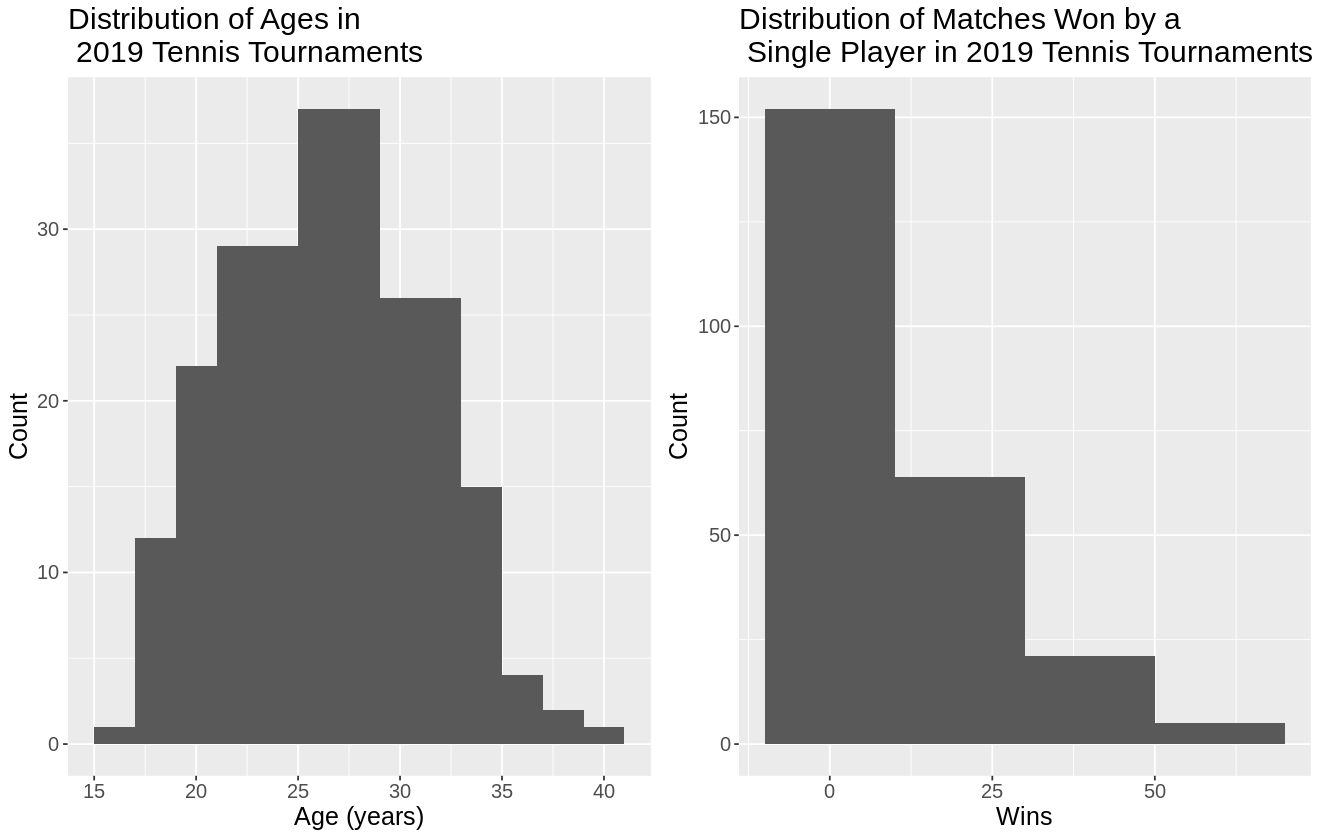

In [25]:
#Age distribution visualization (for entire dataset)
options(repr.plot.height = 7, repr.plot.width = 11)

age_hist <- ggplot(atp_data, aes(x = age)) +
    geom_histogram(binwidth = 2) +
    labs(x = "Age (years)", y = "Count",
         title = "Distribution of Ages in \n 2019 Tennis Tournaments") +
    theme(text = element_text(size = 15))

win_hist <- ggplot(atp_data, aes(x = wins)) +
    geom_histogram(binwidth = 20) +
    labs(x = "Wins", y = "Count",
     title = "Distribution of Matches Won by a \n Single Player in 2019 Tennis Tournaments") +
    theme(text = element_text(size = 15))

plot_grid(age_hist, win_hist, ncol = 2)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
“Removed 60 rows containing non-finite outside the scale range (`stat_bin()`).”
Warning message in ggally_statistic(data = data, mapping = mapping, na.rm = na.rm, :
“Removed 60 rows containing missing values”
Warning message in ggally_statistic(data = data, mapping = mapping, na.rm = na.rm, :
“Removed 60 rows containing missing values”
Warning message in ggally_statistic(data = data, mapping = mapping, na.rm = na.rm, :
“Removed 60 rows containing missing values”
Warning message:
“Removed 60 rows containing missing values or values outside the scale range
(`geom_point()`).”
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
“Removed 60 rows containing non-finite outside the scale range (`stat_bin()`).”
Warning message in ggally_statistic(data = data, mapping = mapping, na.rm = na.rm, :
“Removed 60 rows containing missing values”
Warning message in ggally_statistic(data = 

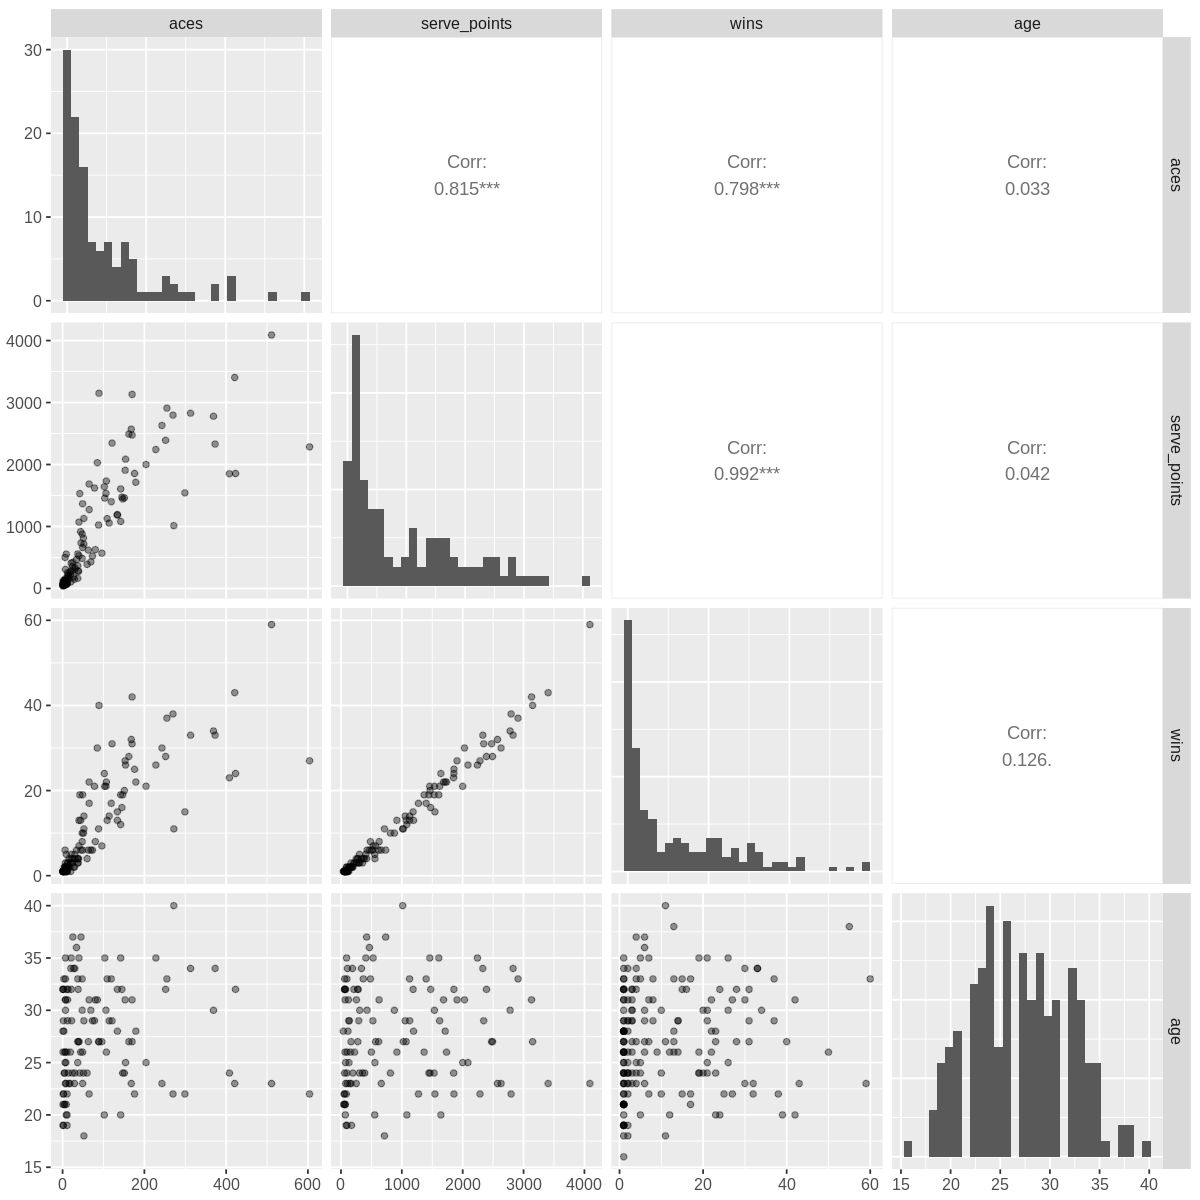

In [38]:
#
options(repr.plot.width = 10, repr.plot.height = 10)

atp_matrix <- atp_training |> 
    ggpairs(
        lower = list(continuous = wrap('points', alpha = 0.4)),
        diag = list(continuous = "barDiag")
    ) +
    theme(text = element_text(size = 12))
atp_matrix

In [26]:
# Define the linear regression model specification 
atp_lm_spec <- linear_reg() |>
  set_engine("lm") |>
  set_mode("regression")

In [27]:
# Define formula for the model
atp_lm_recipe <- recipe(wins ~ aces + serve_points + age, data = atp_training)

In [28]:
# Fit the linear regression model
atp_lm_fit <- workflow() |>
    add_recipe(atp_lm_recipe) |>
    add_model(atp_lm_spec) |>
    fit(atp_training)
atp_lm_fit 

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: linear_reg()

── Preprocessor ────────────────────────────────────────────────────────────────
0 Recipe Steps

── Model ───────────────────────────────────────────────────────────────────────

Call:
stats::lm(formula = ..y ~ ., data = data)

Coefficients:
 (Intercept)          aces  serve_points           age  
    0.438595     -0.003186      0.013139     -0.025216  


In [48]:
# Predict on training data
atp_preds <- atp_lm_fit |>
    predict(atp_training) |>
    bind_cols(atp_training) |>
    rename(predicted_wins = .pred)

Warning message:
“Removed 60 rows containing missing values or values outside the scale range
(`geom_point()`).”


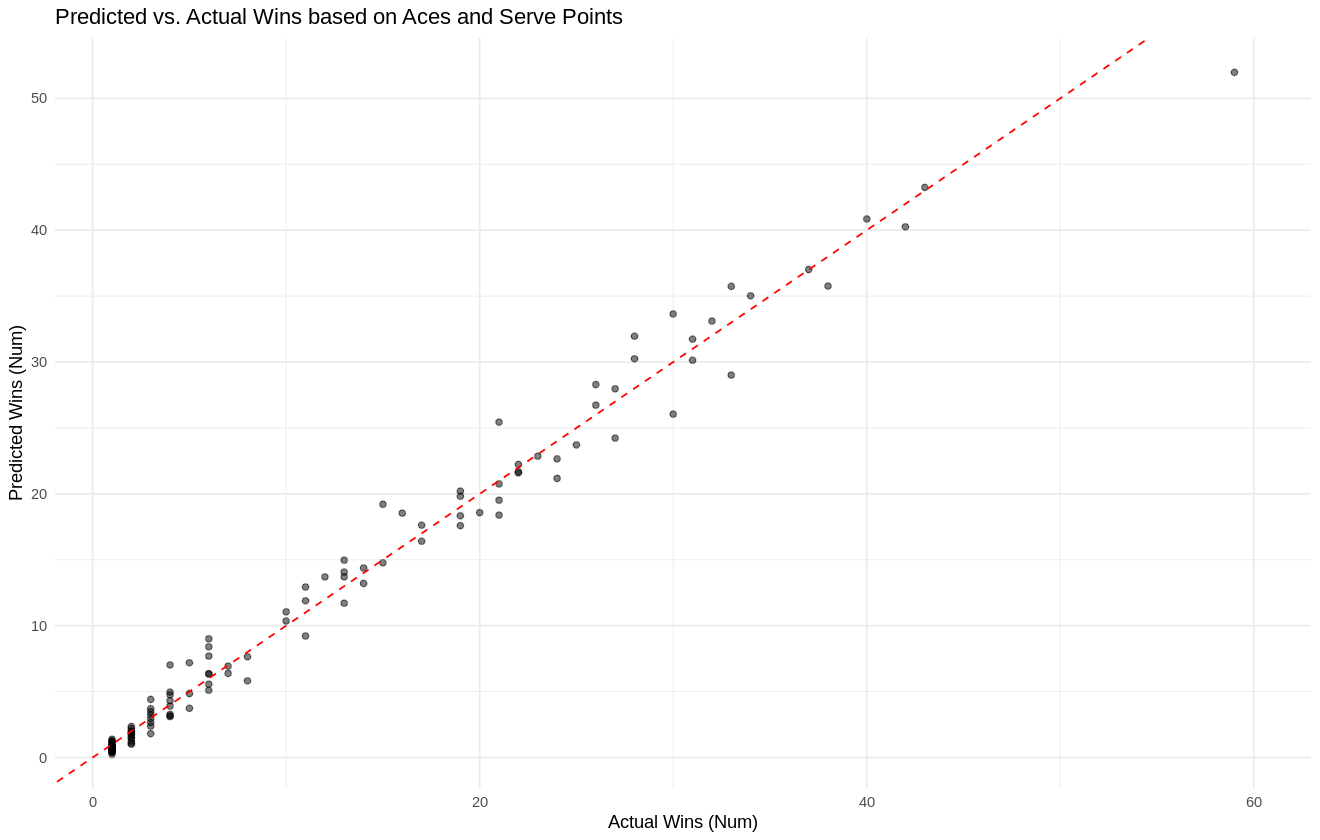

In [12]:
# Actual vs Predicted Wins Visualization
wins_comparsion_plot <- ggplot(atp_preds, aes(x = wins, y = predicted_wins)) +
                        geom_point(alpha = 0.5) +
                        geom_abline(slope = 1, intercept = 0, col = "red", linetype = "dashed") +
                        labs(x = "Actual Wins (Num)", y = "Predicted Wins (Num)",
                        title = "Predicted vs. Actual Wins based on Aces and Serve Points") + 
                        theme(text = element_text(size = 20)) +
                        theme_minimal()
wins_comparsion_plot

In [13]:
# Analysis to visualize how age affects wins
# Calculate average aces and serve points for predictions
avg_aces <- mean(atp_training$aces, na.rm = TRUE)
avg_aces

avg_serve_points <- mean(atp_training$serve_points, na.rm = TRUE)
avg_serve_points

[1] 89.98347

[1] 943.3802

In [14]:
# Generate a new data frame for prediction across a range of ages
age_range <- data.frame(age = seq(min(atp_training$age, na.rm = TRUE), 
                                  max(atp_training$age, na.rm = TRUE), 
                                  length.out = 100),
                        aces = avg_aces,
                        serve_points = avg_serve_points)
head(age_range)

,age,aces,serve_points
,<dbl>,<dbl>,<dbl>
1,16.00000,89.98347,943.3802
2,16.24242,89.98347,943.3802
3,16.48485,89.98347,943.3802
4,16.72727,89.98347,943.3802
5,16.96970,89.98347,943.3802
6,17.21212,89.98347,943.3802


In [15]:
# Predict wins using the model across age range
atp_age_preds <- atp_lm_fit
    predict(age_range) |>
    bind_cols(age_range) |>
    rename(predicted_wins = .pred)

ERROR: Error in UseMethod("predict"): no applicable method for 'predict' applied to an object of class "data.frame"


In [ ]:
# Plot age against predicted wins
ages_plot <- ggplot(age_predictions, aes(x = age, y = predicted_wins)) +
                              geom_line() +
                              scale_x_continuous(breaks = seq(from = floor(min(age_predictions$age)), 
                                  to = ceiling(max(age_predictions$age)), 
                                  by = 1)) +
                              labs(x = "Age (years)", y = "Predicted Wins (Num)",
                              title = "Predicted Wins vs. Player Age") +
                              theme_minimal()

In [ ]:
# Add an overall title
combined_plot <- plot_grid(wins_comparsion_plot, ages_plot, ncol = 2)
overall_title <- ggdraw() + 
  draw_label("Player's Aces, Serve Points (Left) and Age (Right) vs. Number of matches won in 2019", 
             fontface = 'bold', x = 0.5, hjust = 0.5) +
  theme(plot.margin = margin(0, 0, 0, 7))
final_plot <- plot_grid(overall_title, combined_plot, ncol = 1, rel_heights = c(0.1, 1))
final_plot

In [16]:
#
atp_test_results <- atp_lm_fit |>
    predict(atp_testing) |>
    bind_cols(atp_testing) |>
    metrics(truth = wins, estimate = .pred)
atp_test_results

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,1.6045759
rsq,standard,0.9859255
mae,standard,1.0826597


In [17]:
#
atp_rmse <- atp_test_results |>
    filter(.metric == "rmse") |>
    pull()
atp_rmse

[1] 1.604576

In [18]:
#
atp_test_preds <- atp_lm_fit |>
    predict(atp_testing) |>
    bind_cols(atp_testing)
head(atp_test_preds)

.pred,winner_name,aces,serve_points,wins,age
<dbl>,<chr>,<dbl>,<dbl>,<int>,<dbl>
2.7436863,Alejandro Davidovich Fokina,9,216,3,20
0.4015776,Alejandro Gonzalez,1,55,1,30
NA,Aleksandre Metreveli,NA,NA,1,26
4.1324600,Alex Bolt,37,340,3,26
NA,Alexander Zverev,NA,NA,44,22
11.5191180,Andy Murray,96,928,11,32


**Methods** (from proposal)

To investigate the expected wins across several age groups for major tennis tournaments in 2019, we will employ a regression model. To do this we will split the data into a training and testing set to ensure the model is accurat. We will use K-nearest neighbours regression to construct a model, train it with the training data set, and evaluate its performance using cross-validation.

For this analysis, we will focus on the following columns from the data set based in 2019: tourney_date, winner_a, w_ace, w_svpt. Using the predictor variables age, aces, and serve points the regression model will predict the expected number of wins a player will get based on their age, aces and number of serve points.



**Expected outcomes and significance** (from proposal)

We anticipate our regression model will accurately predict the expected number of wins players will get across a variety of age groups in major tournaments. 

Understanding ese valuesewillan provide valuable insigts into the performance of athletewith n regard to their age. This model can aid players, coaches, and analysts in strategizing training regimes, player selection, and scheduling.

Future investigations could explore the impact of additional variables to create more accuracy in determining expected winsrate of an age group suchthe number of double faults or saved break pointsaces with respect to age. Furthermore, extending the set to include other major tournaments in the from several years could a more comprehensive understanding of age-related performance trends in professional tennis.


**Discussion**

Summary:

Comparison to Expectations: 

Impact: 

Future Questions:

**References**

Aku, Y., & Yang, C. B. (2023). The relative age effect among Chinese junior men's tennis players and its impact on sports performance. PloS one, 18(10), e0292443. https://doi.org/10.1371/journal.pone.0292443

Cui, Y., Gómez, M. Á., Gonçalves, B., & Sampaio, J. (2018). Performance profiles of professional female tennis players in grand slams. PloS one, 13(7), e0200591. https://doi.org/10.1371/journal.pone.0200591

Sackmann, J. (2024). atp_matches_2019. tennis_atp. https://github.com/JeffSackmann/tennis_atp

Zháněl, J., Válek, T., Bozděch, M., & Agricola, A. (2022). The relative age effect in top 100 elite female tennis players in 
2007-2016. PloS one, 17(11), e0276668. https://doi.org/10.1371/journal.pone.0276668

